## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.models.cifar10.wideresnet import wrn_22_cat, wrn_22
torch.backends.cudnn.benchmark = True
PATH = Path("data/cifar10/")
os.makedirs(PATH,exist_ok=True)

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

bs=512
sz=32
workers=7

In [4]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

def pad(img, p=4, padding_mode='reflect'):
    return Image.fromarray(np.pad(np.asarray(img), ((p, p), (p, p), (0, 0)), padding_mode))

def torch_loader(data_path, size):
    if not os.path.exists(data_path+'/train'): download_cifar10(data_path)

    # Data loading code
    traindir = os.path.join(data_path, 'train')
    valdir = os.path.join(data_path, 'test')
    normalize = transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])
    tfms = [transforms.ToTensor(), normalize]

    train_tfms = transforms.Compose([
        pad, # TODO: use `padding` rather than assuming 4
        transforms.RandomCrop(size),
        transforms.RandomHorizontalFlip(),
    ] + tfms)
    val_tfms = transforms.Compose(tfms)

    train_dataset = datasets.ImageFolder(traindir, train_tfms)
    val_dataset = datasets.ImageFolder(valdir, val_tfms)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs*2, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [5]:
data = torch_loader(str(PATH), sz)

In [6]:
m = wrn_22_cat()

In [7]:
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 1e-1

In [8]:
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# lr = args.lr
# epoch_sched = [int(args.epochs*o+0.5) for o in (0.47, 0.31, 0.17, 0.05)]
# if args.warmonly:
#     data = [data0,data1]
#     phases = [
#         TrainingPhase(**def_phase, epochs=1, lr=(lr/100,lr), lr_decay=DecayType.LINEAR),
#         TrainingPhase(**def_phase, epochs=1, lr=(lr,lr/100), lr_decay=DecayType.LINEAR)]
# else:
#     data = [data0,data0,data1,data1,data1,data2,data2]
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(lr/200,lr/10), lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=7, lr=(lr/10,lr/2), lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=7, lr=(lr/2,lr/10), lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=3, lr=(lr/10,lr/100), lr_decay=DecayType.LINEAR)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.662039   1.696292   0.4442    
    1      1.27336    1.260788   0.5661                   
    2      0.945429   0.897295   0.6936                    
    3      0.752769   0.730798   0.7485                    
    4      0.60563    0.621861   0.7854                    
    5      0.526326   0.627241   0.7945                    
    6      0.471621   0.631171   0.7822                    
    7      0.44156    0.492612   0.8355                    
    8      0.380013   0.399317   0.8605                    
    9      0.317966   0.3809     0.8725                    
    10     0.271654   0.344888   0.8875                    
    11     0.240416   0.326707   0.8964                    
    12     0.192542   0.324715   0.8984                    
    13     0.154397   0.266097   0.9105                    
    14     0.121361   0.263755   0.9175                    
    15     0.092432   0.244981   0.9272                   

[array([0.23983]), 0.9285000017166137]

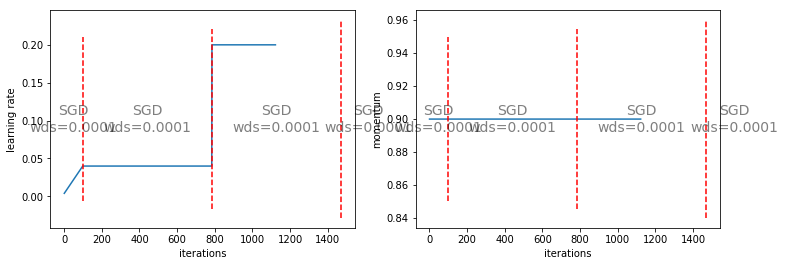

In [19]:
learn.sched.plot_lr()

In [14]:
%time learn.fit(.005, 1, wds=wd, cycle_len=1, loss_scale=512)

 51%|█████     | 50/98 [00:07<00:07,  6.64it/s, loss=2.31]

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.986074   1.823489   0.3445    

CPU times: user 10.1 s, sys: 4.47 s, total: 14.6 s
Wall time: 15.3 s


[array([1.82349]), 0.34450000104904177]

In [15]:
%time learn.fit(lr, 1, wds=wd, cycle_len=20, use_clr_beta=(12,15,0.95,0.85), loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.752462   2.089988   0.3653    
    1      1.415329   1.277752   0.5432                   
    2      1.03773    0.896488   0.6782                   
    3      0.813492   0.775105   0.7253                    
    4      0.684075   0.725958   0.749                     
    5      0.573127   0.63228    0.7859                    
    6      0.515764   0.531604   0.8106                    
    7      0.473965   0.660552   0.7841                    
    8      0.418588   0.505136   0.8285                    
    9      0.364027   0.452368   0.8493                    
    10     0.328663   0.418461   0.8598                    
    11     0.293754   0.410593   0.8596                    
    12     0.269821   0.346743   0.8836                    
    13     0.236393   0.305855   0.8981                    
    14     0.190974   0.316761   0.8996                    
    15     0.161148   0.289981   0.9077                    

[array([0.24707]), 0.9243000017166138]